# Example : entropy calculations

(c) Charles Le Losq and contributors, 2021-2023
see embedded licence file

In this notebook we show how one can use i-Melt to observe how properties like configurational entropy change with composition in a systematic way.

We focus on building contour maps of variations in entropy with SiO$_2$, Al$_2$O$_3$, and mixing 2 metal cations.

### Library loading and additional function definition

In [1]:
%matplotlib inline

# dataframes and arrays
import pandas as pd 
import numpy as np

# for plotting
import matplotlib.pyplot as plt 
import matplotlib, mpltern#, corner
from mpltern.ternary.datasets import get_spiral
from matplotlib.patches import ArrowStyle, FancyArrowPatch
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

# spearman corr coef
from scipy.stats import spearmanr

# neuravi internals
import src.imelt as imelt
import src.utils as utils

# other essentials
import torch, time, h5py

# we will work on CPU there
device = torch.device('cpu') #get_default_device()
print(device)

cpu


### Loading dataset and models

In [2]:
# data are loaded using the data_loader helper.
ds = imelt.data_loader()

# The 10 models are loaded through a bagging class.
neuralmodel = imelt.load_pretrained_bagged(activation_function=torch.nn.GELU())

### Visualizing how entropy changes during mixing of cations

We first observe how entropy changes with mixing metal cations at variable SiO2 and Al2O3 contents.

In [3]:
def generate_compo(sio2,R_MAl,cation1="na2o",cation2="k2o"):
    
    # First we check the cations that were selected
    if (cation1 == "na2o") & (cation2 == "k2o"):
        cation3 = "mgo"
        cation4 = "cao"
    elif (cation1 == "na2o") & (cation2 == "mgo"):
        cation3 = "k2o"
        cation4 = "cao"
    elif (cation1 == "na2o") & (cation2 == "cao"):
        cation3 = "k2o"
        cation4 = "mgo"
    elif (cation1 == "k2o") & (cation2 == "mgo"):
        cation3 = "na2o"
        cation4 = "cao"
    elif (cation1 == "k2o") & (cation2 == "cao"):
        cation3 = "na2o"
        cation4 = "mgo"
    elif (cation1 == "mgo") & (cation2 == "cao"):
        cation3 = "na2o"
        cation4 = "k2o"
    
    # generating starting arrays
    xk = np.linspace(0.,1.,500)
    out=np.zeros((len(sio2)*500,7))

    # Generating the initial dataframe
    for i in range(0,len(sio2)):
        out[i*500:(i+1)*500,0] = sio2[i] # first column is sio2
        out[i*500:(i+1)*500,-1] = xk # last column is xk

    master_df = pd.DataFrame(data=out, columns=["sio2","al2o3","na2o","k2o","mgo","cao","xk"])
    master_df.loc[:,'al2o3'] = R_MAl * (1.0 - master_df.loc[:,'sio2'])
    metals = 1.0 - master_df['sio2'] - master_df['al2o3']
    master_df[cation1] = (1.0-master_df.loc[:,"xk"])*metals
    master_df[cation2] = master_df.loc[:,"xk"]*metals
    master_df[cation3] = 0.0
    master_df[cation4] = 0.0

    return master_df

# below we generate compositions

# SiO2 between 50 and 100% (nearly)
sio2_gen = np.arange(0.5,0.999,0.005)

# Na-K mixtures
X_gen_RS_nak_rec = generate_compo(sio2_gen, 0.00, cation1="na2o", cation2="k2o")
X_gen_R3_nak_rec = generate_compo(sio2_gen, 0.25, cation1="na2o", cation2="k2o")
X_gen_R1_nak_rec = generate_compo(sio2_gen, 0.50, cation1="na2o", cation2="k2o")

# Ca-Mg mixtures
X_gen_RS_camg_rec = generate_compo(sio2_gen, 0.00, cation1="mgo", cation2="cao")
X_gen_R3_camg_rec = generate_compo(sio2_gen, 0.25, cation1="mgo", cation2="cao")
X_gen_R1_camg_rec = generate_compo(sio2_gen, 0.50, cation1="mgo", cation2="cao")

### We now calculate the glass residual entropy at Tg.

In [4]:
sctg_RS_nak_rec  = neuralmodel.predict("sctg",utils.descriptors(X_gen_RS_nak_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())
sctg_R3_nak_rec  = neuralmodel.predict("sctg",utils.descriptors(X_gen_R3_nak_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())
sctg_R1_nak_rec  = neuralmodel.predict("sctg",utils.descriptors(X_gen_R1_nak_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())
sctg_RS_camg_rec = neuralmodel.predict("sctg",utils.descriptors(X_gen_RS_camg_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())
sctg_R3_camg_rec = neuralmodel.predict("sctg",utils.descriptors(X_gen_R3_camg_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())
sctg_R1_camg_rec = neuralmodel.predict("sctg",utils.descriptors(X_gen_R1_camg_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())

### And we do a figure 

It plots contour maps of the entropy as a function of chemistry.

First line will be Na-K mixtures, second Ca-Mg ones.

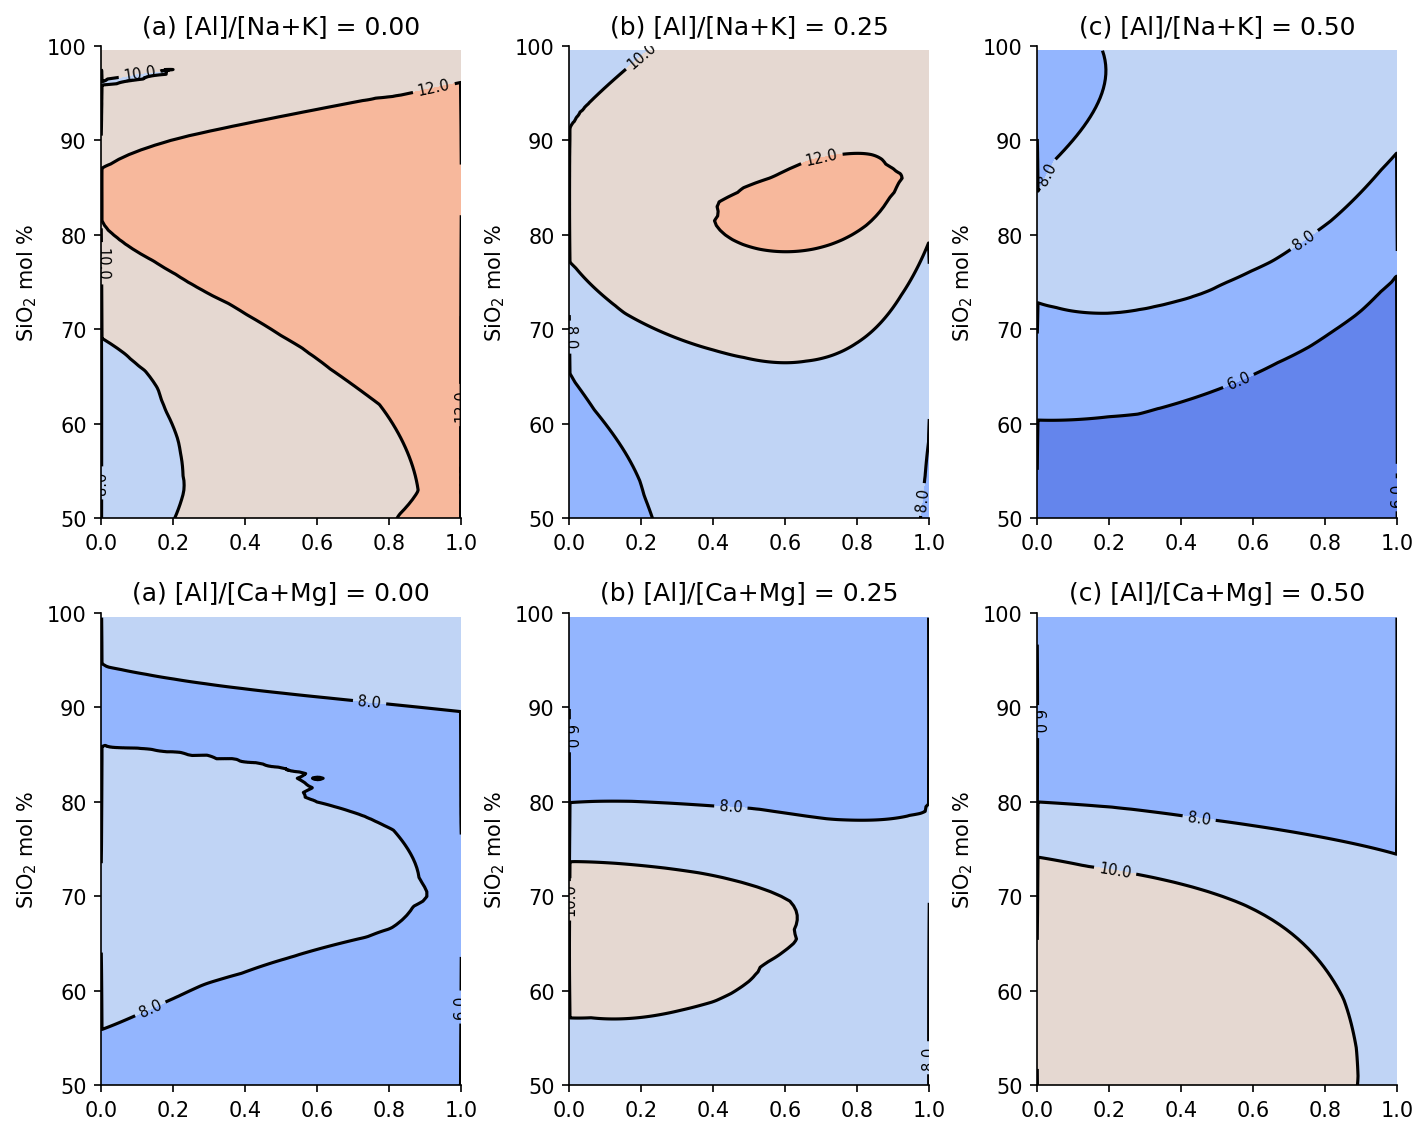

In [10]:
def entro_mix_fig(ax1, X, y, title_string, set_y_label=True,
                  norm = matplotlib.colors.Normalize(vmin=3.0,vmax=18.0), # Manual setup
                    c_m = matplotlib.cm.coolwarm, # choose a colormap
                    levels = np.arange(0,20,2),
                    levels_l = np.arange(0,20,2)):
    """helper function for the figure"""
    
    s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm) # create a ScalarMappable and initialize a data structure
    
    tc1 = ax1.tricontourf(X.loc[:,"xk"], 
                X.loc[:,"sio2"]*100, 
                y, 
                levels=levels, cmap=c_m, norm=norm)
    tc1_l = ax1.tricontour(X.loc[:,"xk"], 
                    X.loc[:,"sio2"]*100, 
                    y, 
                    levels=levels_l, colors='k', norm=norm)
    ax1.clabel(tc1_l, inline=1, fontsize=7, fmt="%1.1f")

    ax1.set_xlim(0,1)
    ax1.set_ylim(50,100.)

    if set_y_label == True:
        ax1.set_ylabel(r"SiO$_2$ mol %")

    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    # Title
    ax1.set_title(title_string, loc='center')
    return ax1

#
# Figure generation
#

fig11 = plt.figure(figsize=(9,9), dpi=150, constrained_layout=False)

gs1 = fig11.add_gridspec(nrows=2, ncols=3, 
                        left=0.02, right=0.98,
                        #bottom = 0.55, top = 0.95,
                        wspace=0.3, hspace=0.2)
ax1 = fig11.add_subplot(gs1[0,0])
ax2 = fig11.add_subplot(gs1[0,1])
ax3 = fig11.add_subplot(gs1[0,2])
ax4 = fig11.add_subplot(gs1[1,0])
ax5 = fig11.add_subplot(gs1[1,1])
ax6 = fig11.add_subplot(gs1[1,2])

####
#### XK along near tectosilicate joint
####
ax1 = entro_mix_fig(ax1, X_gen_RS_nak_rec, sctg_RS_nak_rec, "(a) [Al]/[Na+K] = 0.00")
ax2 = entro_mix_fig(ax2, X_gen_R3_nak_rec, sctg_R3_nak_rec, "(b) [Al]/[Na+K] = 0.25")
ax3 = entro_mix_fig(ax3, X_gen_R1_nak_rec, sctg_R1_nak_rec, "(c) [Al]/[Na+K] = 0.50")
ax4 = entro_mix_fig(ax4, X_gen_RS_camg_rec, sctg_RS_camg_rec, "(a) [Al]/[Ca+Mg] = 0.00")
ax5 = entro_mix_fig(ax5, X_gen_R3_camg_rec, sctg_R3_camg_rec, "(b) [Al]/[Ca+Mg] = 0.25")
ax6 = entro_mix_fig(ax6, X_gen_R1_camg_rec, sctg_R1_camg_rec, "(c) [Al]/[Ca+Mg] = 0.50")

plt.show()

### That's it !

This example can be changed as needed, for instance plotting $T_g$ or density as a function of composition, or observing other mixtures like Na-Ca or Na-Mg, etc.